In [1]:
!pip install geopy
!pip install bs4
!pip install lxml
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import lxml
print('Libraries imported.')

     |████████████████████████████████| 122kB 6.2MB/s eta 0:00:01
     |████████████████████████████████| 112kB 10.9MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 5.8MB 7.7MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noa

In [2]:
vienna = pd.read_csv('https://raw.githubusercontent.com/MyroslavY/github-example/master/Vienna.csv')
vienna

,District,Population,Latitude,Longitude
0,Innere Stadt,16409,48.205833,16.368665
1,Leopoldstadt,103233,48.206166,16.407332
2,Landstrasse,89834,48.191166,16.390832
3,Wieden,32745,48.186999,16.356999
4,Mariahilf,31621,48.190499,16.343165
5,Josefstadt,25068,48.206499,16.342165
6,Alsergrund,43342,48.221832,16.354165
7,Favoriten,19482,48.154666,16.355499
8,Simmering,97333,48.174000,16.416000
9,Meidling,94179,48.156999,16.319665


### Rename the column District to Neighborhood

In [3]:
vienna.rename(columns={'District': 'Neighborhood'}, inplace=True)
vienna

,Neighborhood,Population,Latitude,Longitude
0,Innere Stadt,16409,48.205833,16.368665
1,Leopoldstadt,103233,48.206166,16.407332
2,Landstrasse,89834,48.191166,16.390832
3,Wieden,32745,48.186999,16.356999
4,Mariahilf,31621,48.190499,16.343165
5,Josefstadt,25068,48.206499,16.342165
6,Alsergrund,43342,48.221832,16.354165
7,Favoriten,19482,48.154666,16.355499
8,Simmering,97333,48.174000,16.416000
9,Meidling,94179,48.156999,16.319665


### We now have located and imported the relevant data for the districts of Vienna, and have constructed a dataframe.

Our business objective, strategy and methods to achieve our goal have been laid out, and a data workflow established.

Next up, we will leverage Foursquare location data to obtain data on high traffic areas - where consumers go for shopping, restaurants and entertainment - in all of the 21 districts.

In [4]:
# Check the shape of the dataframe
vienna.shape

(21, 4)

### Use the geopy library to get the latitude and longitude values of Vienna

In [5]:
#Retrieve the Latitude and Longitude for Vienna
from geopy.geocoders import Nominatim 

address = 'Vienna'

# Define the user_agent as Vienna_explorer
geolocator = Nominatim(user_agent="Vienna_explorer")

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinates of Vienna Austria are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Vienna Austria are 48.2083537, 16.3725042.


### Create a map of Vienna with districts superimposed

In [6]:
# create map of Paris using the above latitude and longitude values
map_vienna = folium.Map(location=[latitude, longitude], zoom_start=11)


# add markers to map
for lat, lng, label in zip(vienna['Latitude'], vienna['Longitude'], vienna['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=25,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_vienna)  
    
map_vienna

### Use the Foursquare API to explore the Neighborhoods of Vienna

#### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = '5VSIIVDJ4LSBKW3RI45BBAVIC2MFNYMDAK5HCVWYS4GRG1QS' # your Foursquare ID
CLIENT_SECRET = 'L5PHIRYNMOBNB5INMT1TETZIA3MQE4BDYLW0I2HPR3R3XXNG' # your Foursquare Secret
VERSION = '20200512' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5VSIIVDJ4LSBKW3RI45BBAVIC2MFNYMDAK5HCVWYS4GRG1QS
CLIENT_SECRET:L5PHIRYNMOBNB5INMT1TETZIA3MQE4BDYLW0I2HPR3R3XXNG


### Exploratory data analysis
##### Explore the first district in our dataframe to become familiar with the data

In [8]:
# Explore the first Neighborhood in our dataframe.
# Get the Neighborhood's French name.

vienna.loc[0, 'Neighborhood']
vienna.loc[0, 'Neighborhood']

'Innere Stadt'

### The first Neighborhood is identified as "Innere Stadt"

In [9]:
# Get the Neighborhood's latitude and longitude values.

neighborhood_latitude = vienna.loc[0, 'Latitude'] # Neighborhood latitude value
neighborhood_longitude = vienna.loc[0, 'Longitude'] # Neighborhood longitude value

neighborhood_name = vienna.loc[0, 'Neighborhood'] # Neighborhood name

print('Latitude and longitude values of the neighborhood {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of the neighborhood Innere Stadt are 48.20583251, 16.36866519.


#### Get the top 100 venues that are in the neighborhood Innere Stadt within a radius of 500 meters

In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # displays the URL

'https://api.foursquare.com/v2/venues/explore?&client_id=5VSIIVDJ4LSBKW3RI45BBAVIC2MFNYMDAK5HCVWYS4GRG1QS&client_secret=L5PHIRYNMOBNB5INMT1TETZIA3MQE4BDYLW0I2HPR3R3XXNG&v=20200512&ll=48.20583251,16.36866519&radius=500&limit=100'

In [11]:
# Send the GET request and examine the resutls

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ebc3252be61c9001b9b0852'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Kärntner Viertel',
  'headerFullLocation': 'Kärntner Viertel, Vienna',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 41,
  'suggestedBounds': {'ne': {'lat': 48.2103325145, 'lng': 16.37540471754289},
   'sw': {'lat': 48.2013325055, 'lng': 16.361925662457114}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b058894f964a520c4ce22e3',
       'name': 'Albertina',
       'location': {'address': 'Albertinaplatz 1',
        'lat': 48.20461950049964,
        'lng': 16.368255615234375,
        'labeledLatLngs': [{'label': 'display',
          'lat': 48.2046195

### Define the function that extracts the category of the venue

In [12]:
# define a function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Structure the json file into a pandas dataframe

In [13]:
# clean the json and structure it into a pandas dataframe.

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(20)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,lat,lng
0,Albertina,Art Museum,48.204620,16.368256
1,1010 BAR CAFE,Bar,48.206445,16.370218
2,Prunksaal der Nationalbibliothek,Historic Site,48.206182,16.366775
3,Nightfly's Club American Bar,Cocktail Bar,48.207055,16.368883
4,The Guesthouse Vienna,Hotel,48.204784,16.368875
5,Hofburg,Palace,48.206629,16.365595
6,Albertinaplatz,Plaza,48.204319,16.368909
7,Hotel Sacher,Hotel,48.203798,16.369702
8,Dorotheum,Antique Shop,48.206340,16.368630
9,Michaelerplatz,Plaza,48.208007,16.366625


In [14]:
# Check how many venues there are in 3eme Ardt within a radius of 500 meters

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

41 venues were returned by Foursquare.


#### Create a nearby venues function for all the neighborhoods in Vienna

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Create a new dataframe called for the venues of Vienna called vienna-venues

In [16]:
#Create a new dataframe called vienna_venues.
vienna_venues = getNearbyVenues(names=vienna['Neighborhood'],
                                   latitudes=vienna['Latitude'],
                                   longitudes=vienna['Longitude']
                                  )

Innere Stadt
Leopoldstadt
Landstrasse
Wieden
Mariahilf
Josefstadt
Alsergrund
Favoriten
Simmering
Meidling
Hietzing
Penzing
Rudolfsheim-Funfhaus
Ottakring
Hernals
Wahring
Dobling
Brigittenau
Floridsdorf
Donaustadt
Liesing


In [17]:
print(vienna_venues.shape)
vienna_venues.head(250)

(390, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.205833,16.368665,Albertina,48.204620,16.368256,Art Museum
1,Innere Stadt,48.205833,16.368665,1010 BAR CAFE,48.206445,16.370218,Bar
2,Innere Stadt,48.205833,16.368665,Prunksaal der Nationalbibliothek,48.206182,16.366775,Historic Site
3,Innere Stadt,48.205833,16.368665,Nightfly's Club American Bar,48.207055,16.368883,Cocktail Bar
4,Innere Stadt,48.205833,16.368665,The Guesthouse Vienna,48.204784,16.368875,Hotel
5,Innere Stadt,48.205833,16.368665,Hofburg,48.206629,16.365595,Palace
6,Innere Stadt,48.205833,16.368665,Albertinaplatz,48.204319,16.368909,Plaza
7,Innere Stadt,48.205833,16.368665,Hotel Sacher,48.203798,16.369702,Hotel
8,Innere Stadt,48.205833,16.368665,Dorotheum,48.206340,16.368630,Antique Shop
9,Innere Stadt,48.205833,16.368665,Michaelerplatz,48.208007,16.366625,Plaza


## Check how many venues were returned for each neighborhood
### Please be aware of the 100 venue limit imposed by the free Foursquare account.

In [18]:
vienna_venues.groupby('Neighborhood').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alsergrund,62,62,62,62,62,62
Brigittenau,14,14,14,14,14,14
Dobling,6,6,6,6,6,6
Donaustadt,7,7,7,7,7,7
Favoriten,5,5,5,5,5,5
Floridsdorf,10,10,10,10,10,10
Hietzing,5,5,5,5,5,5
Innere Stadt,41,41,41,41,41,41
Josefstadt,41,41,41,41,41,41


### Calculate how many unique venue categories there are

In [19]:
# Calculate how many unique categories there are.
print('There are {} unique venue categories.'.format(len(vienna_venues['Venue Category'].unique())))

There are 130 unique venue categories.


### Analyze each of the Neighborhoods

In [20]:
# one hot encoding
vienna_onehot = pd.get_dummies(vienna_venues[['Venue Category']], prefix="", prefix_sep="")
vienna_onehot['Neighborhood']= vienna_venues['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [vienna_onehot.columns[-1]] + list(vienna_onehot.columns[:-1])
vienna_onehot = vienna_onehot[fixed_columns]

vienna_onehot

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beer Garden,Bike Rental / Bike Share,Boutique,Breakfast Spot,Brewery,Bulgarian Restaurant,Burger Joint,Bus Stop,Butcher,Café,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Discount Store,Dog Run,Doner Restaurant,Drugstore,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Farm,Farmers Market,Fast Food Restaurant,Food,French Restaurant,Furniture / Home Store,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Museum,Music Venue,Opera House,Organic Grocery,Palace,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Recreation Center,Restaurant,River,Romanian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Trail,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop
0,Innere Stadt,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Innere Stadt,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [21]:
# The shape of the dataframe is
vienna_onehot.shape

(390, 131)

### Group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [22]:
vienna_grouped = vienna_onehot.groupby('Neighborhood').mean().reset_index()
vienna_grouped

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beer Garden,Bike Rental / Bike Share,Boutique,Breakfast Spot,Brewery,Bulgarian Restaurant,Burger Joint,Bus Stop,Butcher,Café,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Discount Store,Dog Run,Doner Restaurant,Drugstore,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Farm,Farmers Market,Fast Food Restaurant,Food,French Restaurant,Furniture / Home Store,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Korean Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Museum,Music Venue,Opera House,Organic Grocery,Palace,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Recreation Center,Restaurant,River,Romanian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Trail,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop
0,Alsergrund,0.00000,0.00000,0.00000,0.00000,0.000000,0.032258,0.000000,0.016129,0.016129,0.048387,0.016129,0.000000,0.000000,0.000000,0.016129,0.00000,0.016129,0.016129,0.000000,0.016129,0.016129,0.000000,0.096774,0.000000,0.00000,0.000000,0.00000,0.016129,0.000000,0.000000,0.00000,0.016129,0.016129,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.016129,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.016129,0.000000,0.000000,0.000000,0.000000,0.00000,0.016129,0.00000,0.0,0.00000,0.000000,0.064516,0.000000,0.016129,0.016129,0.00000,0.000000,0.032258,0.016129,0.000000,0.032258,0.000000,0.000000,0.016129,0.000000,0.000000,0.000000,0.016129,0.016129,0.016129,0.016129,0.00000,0.016129,0.032258,0.00000,0.00000,0.000000,0.000000,0.016129,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.016129,0.016129,0.000000,0.080645,0.0,0.000000,0.000000,0.016129,0.000000,0.000000,0.000000,0.00000,0.000000,0.016129,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.016129,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.032258,0.000000,0.016129,0.016129,0.000000,0.0,0.0
1,Brigittenau,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.071429,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.071429,0.00000,0.000000,0.000000,0.000000,0.000000,0.071429,0.00000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.071429,0.00000,0.00000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0000

In [23]:
# The shape of the grouped data is
vienna_grouped.shape

(20, 131)

### Print each neighborhood with it's top 10 most common venues

In [24]:
# Each  neighborhood with top 10 most common venues

num_top_venues = 10

for hood in vienna_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = vienna_grouped[vienna_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alsergrund----
                venue  freq
0                Café  0.10
1          Restaurant  0.08
2               Hotel  0.06
3              Bakery  0.05
4        Tram Station  0.03
5         Supermarket  0.03
6                Park  0.03
7  Italian Restaurant  0.03
8   Korean Restaurant  0.03
9    Asian Restaurant  0.03


----Brigittenau----
            venue  freq
0     Supermarket  0.14
1          Bakery  0.14
2        Bus Stop  0.14
3           Plaza  0.07
4       Gastropub  0.07
5       Pet Store  0.07
6            Park  0.07
7        Gym Pool  0.07
8  Scenic Lookout  0.07
9    Tram Station  0.07


----Dobling----
                   venue  freq
0             Restaurant  0.33
1         Scenic Lookout  0.17
2               Bus Stop  0.17
3                   Farm  0.17
4               Vineyard  0.17
5                    Pub  0.00
6  Portuguese Restaurant  0.00
7                   Pool  0.00
8      Polish Restaurant  0.00
9       Pedestrian Plaza  0.00


----Donaustadt----
       

### Put that data into a pandas dataframe and sort the venues in descending order

In [25]:
# First sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# The top 10 venue categories for each neighborhood
#### This is a very useful results table that can provide at a glance information for all of the districts. Even once any conclusions are drawn further into the data workflow, we can refer back to this table for meaaningful insights about the top categories of businesses in all the neighbourhoods. Even without actual counts and numbers, it makes a great reference table for the client.

In [26]:
# create the new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
vienna_venues_sorted = pd.DataFrame(columns=columns)
vienna_venues_sorted['Neighborhood'] = vienna_grouped['Neighborhood']

for ind in np.arange(vienna_grouped.shape[0]):
    vienna_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vienna_grouped.iloc[ind, :], num_top_venues)

vienna_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsergrund,Café,Restaurant,Hotel,Bakery,Korean Restaurant,Supermarket,Tram Station,Park,Asian Restaurant,Italian Restaurant
1,Brigittenau,Bus Stop,Supermarket,Bakery,Gastropub,Pet Store,Park,Scenic Lookout,Austrian Restaurant,Gym Pool,Tram Station
2,Dobling,Restaurant,Vineyard,Bus Stop,Scenic Lookout,Farm,Wine Shop,Electronics Store,Fast Food Restaurant,Farmers Market,Ethiopian Restaurant
3,Donaustadt,Breakfast Spot,Plaza,Restaurant,Italian Restaurant,Tram Station,Pizza Place,Supermarket,Ethiopian Restaurant,Food,Fast Food Restaurant
4,Favoriten,Tram Station,Park,Plaza,Wine Shop,Ethiopian Restaurant,Food,Fast Food Restaurant,Farmers Market,Farm,Dumpling Restaurant
5,Floridsdorf,Gastropub,Grocery Store,Light Rail Station,Fast Food Restaurant,Supermarket,Wine Shop,River,Wine Bar,Doner Restaurant,Drugstore
6,Hietzing,Tennis Court,Restaurant,Park,Bus Stop,Wine Shop,Ethiopian Restaurant,Fast Food Restaurant,Farmers Market,Farm,Electronics Store
7,Innere Stadt,Plaza,Hotel,Bar,Pedestrian Plaza,Park,Supermarket,Museum,Clothing Store,Gourmet Shop,Café
8,Josefstadt,Supermarket,Mediterranean Restaurant,Asian Restaurant,Indie Movie Theater,Polish Restaurant,Persian Restaurant,Organic Grocery,Japanese Restaurant,Italian Restaurant,Hungarian Restaurant
9,Landstrasse,Supermarket,Pizza Place,Hotel,Plaza,Pharmacy,Market,Bar,Korean Restaurant,Bakery,Tram Station


In [27]:
# The shape of the sorted data is
vienna_venues_sorted.shape

(20, 11)

### The business types criteria specified by the client! 'Restaurant' and 'Italian Restaurant';
Let's look at their frequency of occurrence for all the Vienna neighborhoods, isolating the categorical venues
These are the types of places that the client wants to have in abundance in order to gain their market share. I've used a violin plot from the seaborn library - it is a great way to visualize frequency distribution datasets, they display a density estimation of the underlying distribution.

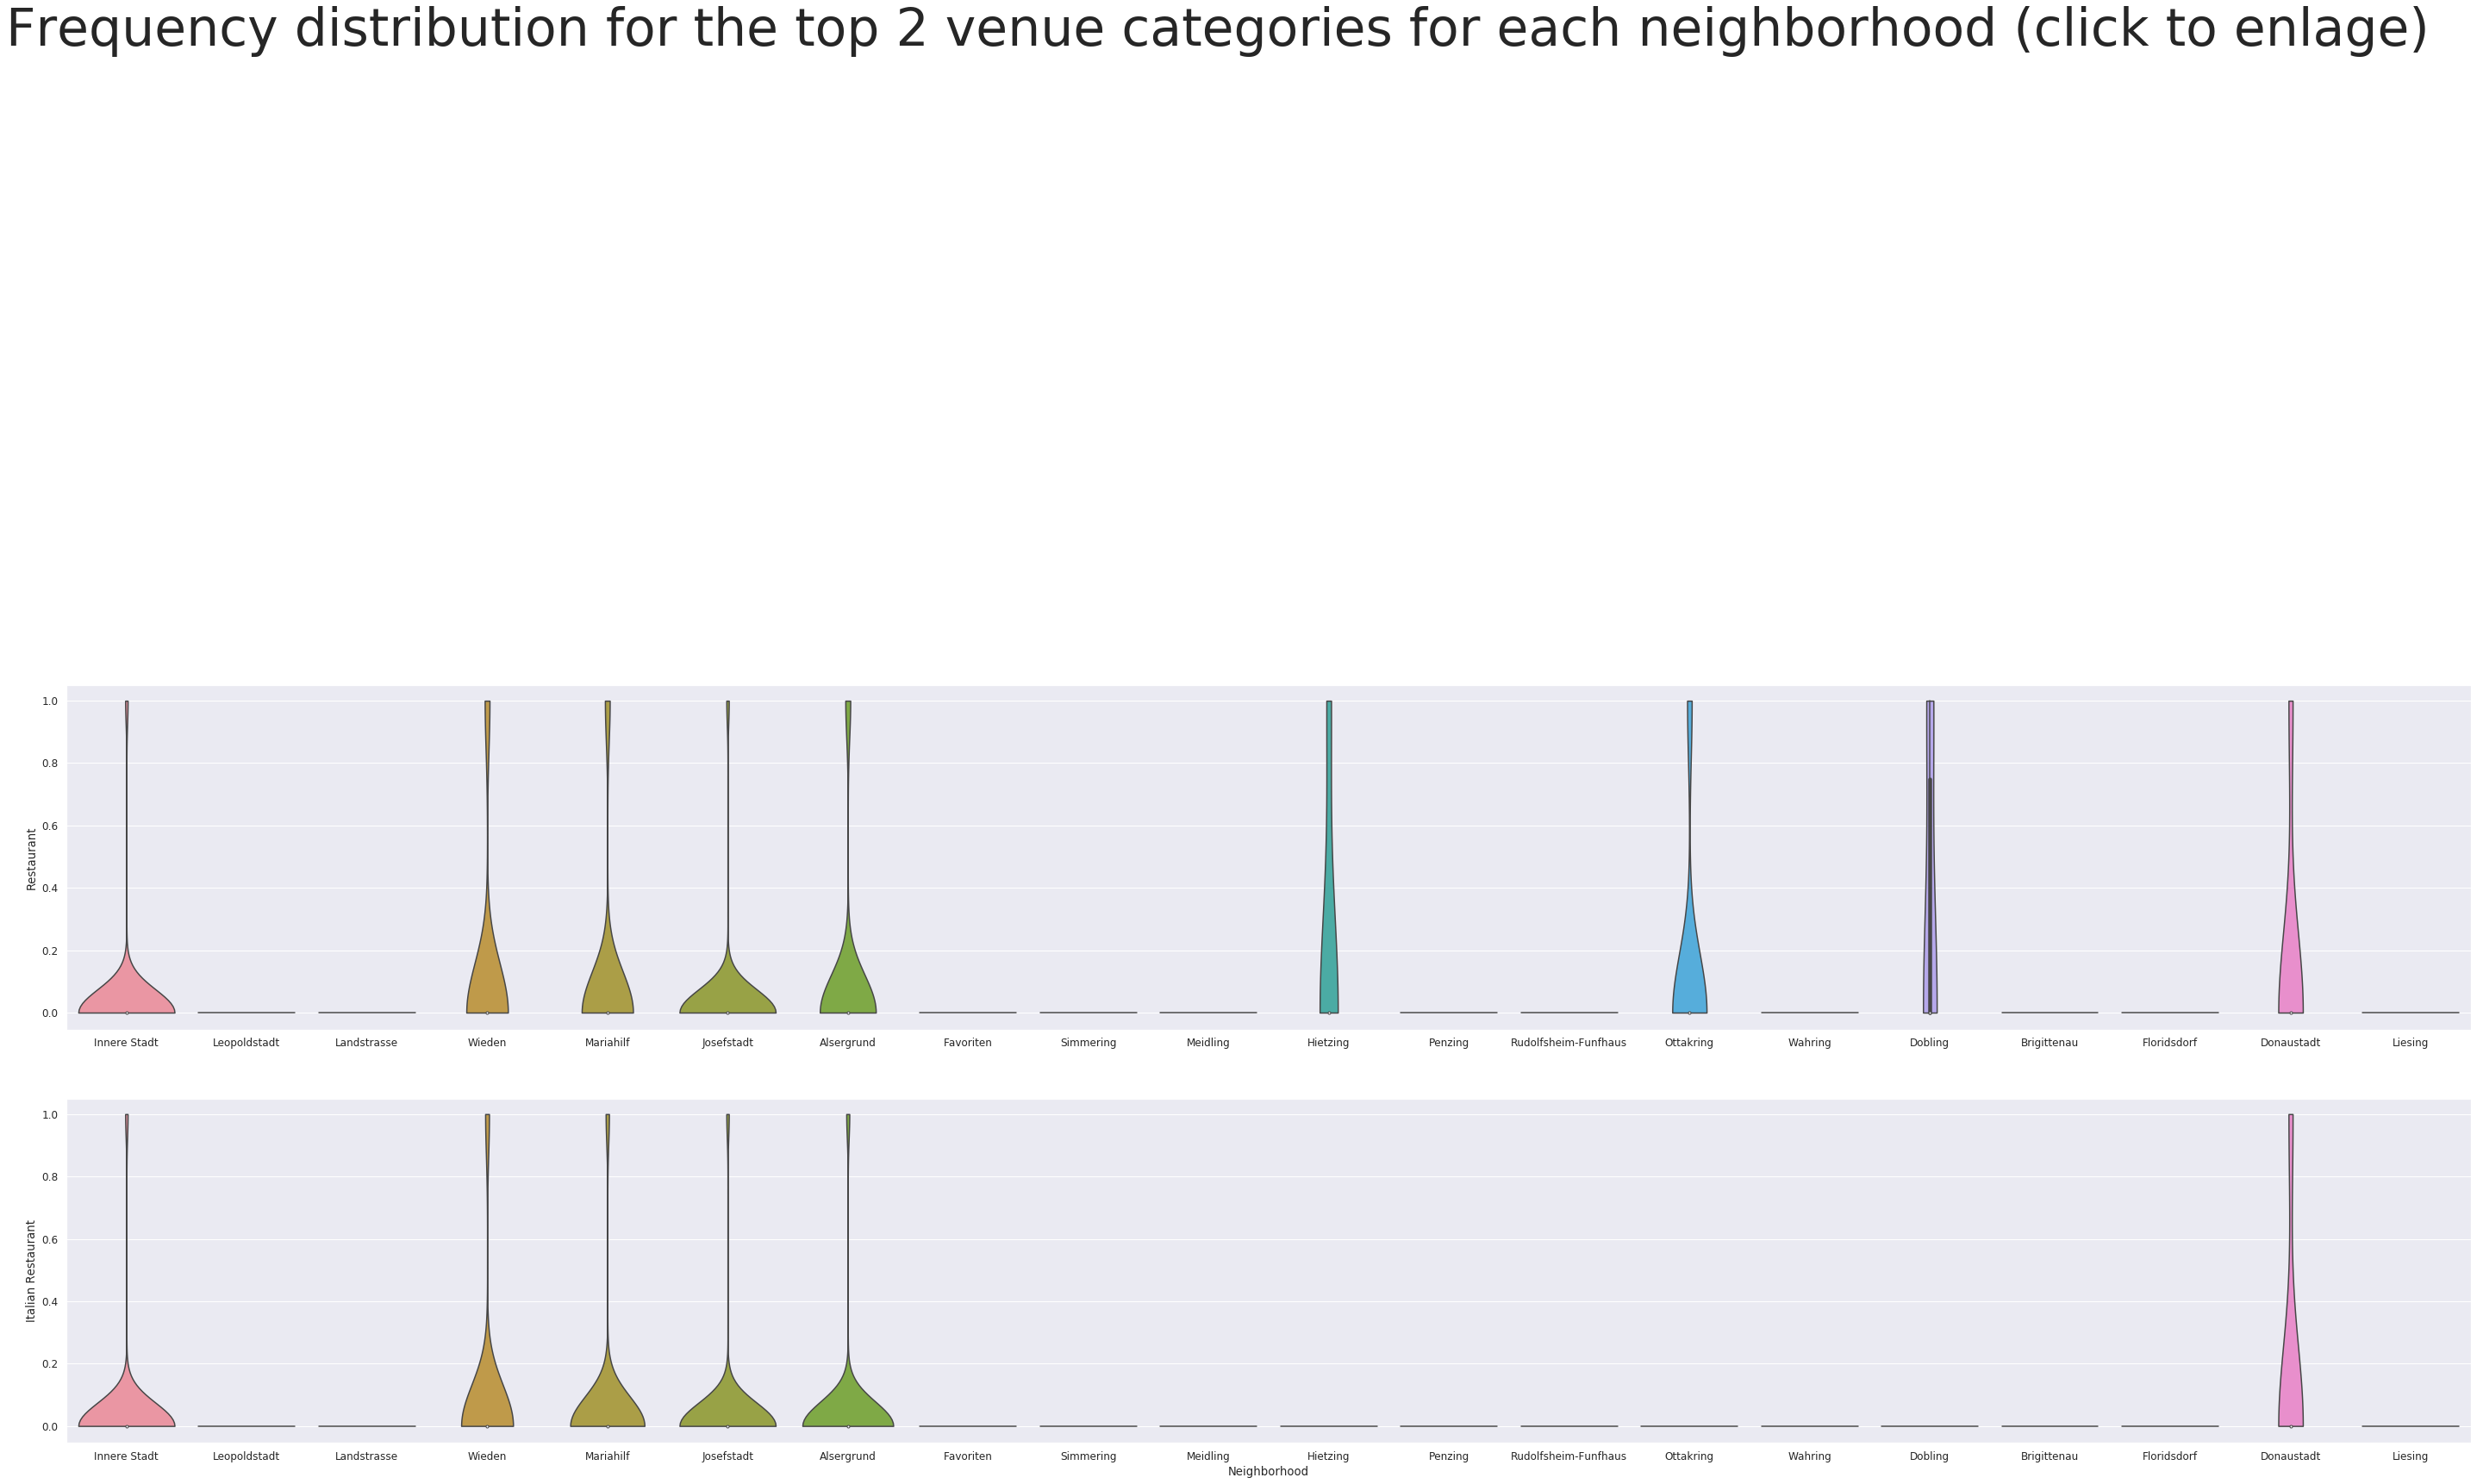

In [28]:
# Categorical plot
# Explore a plot of this data (a violin plot is used which is a density estimation of the underlying distribution).
# The top 2 venue types as specified by the client for each neighborhood are used for the plotting.
from matplotlib import pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)


ax = plt.subplot(3,1,2)
sns.violinplot(x="Neighborhood", y="Restaurant", data=vienna_onehot, cut=0);
plt.xlabel("")

plt.subplot(3,1,3)
sns.violinplot(x="Neighborhood", y="Italian Restaurant", data=vienna_onehot, cut=0);

ax.text(-1.0, 3.1, 'Frequency distribution for the top 2 venue categories for each neighborhood (click to enlage)', fontsize=60)
plt.savefig ("Distribution_Frequency_Venues_2_categories.png", dpi=240)
plt.show()

# The Neighborhoods
So as we can see from the analysis there are 6 neighborhoods to open new restaurant - according to the criteria that they have the 3 specified venues in a great frequency Italian Restaurant and Restaurants. They are as follows:

Neighborhoods

* Inner Stadt
* Wieden
* Mariahilf
* Josefstadt
* Alsergrund
* Donaustadt


#### Let's take this further with some exploration and Inferential Analysis¶
We have the 6 neighborhoods that all include the venue category criteria.
But if we included the 'Café" venue category into the analysis, then we might be able to make some inferences based on the data, and domain knowledge of marketing and the industry, to focus the list.

Let's look at the venue category - 'Café'

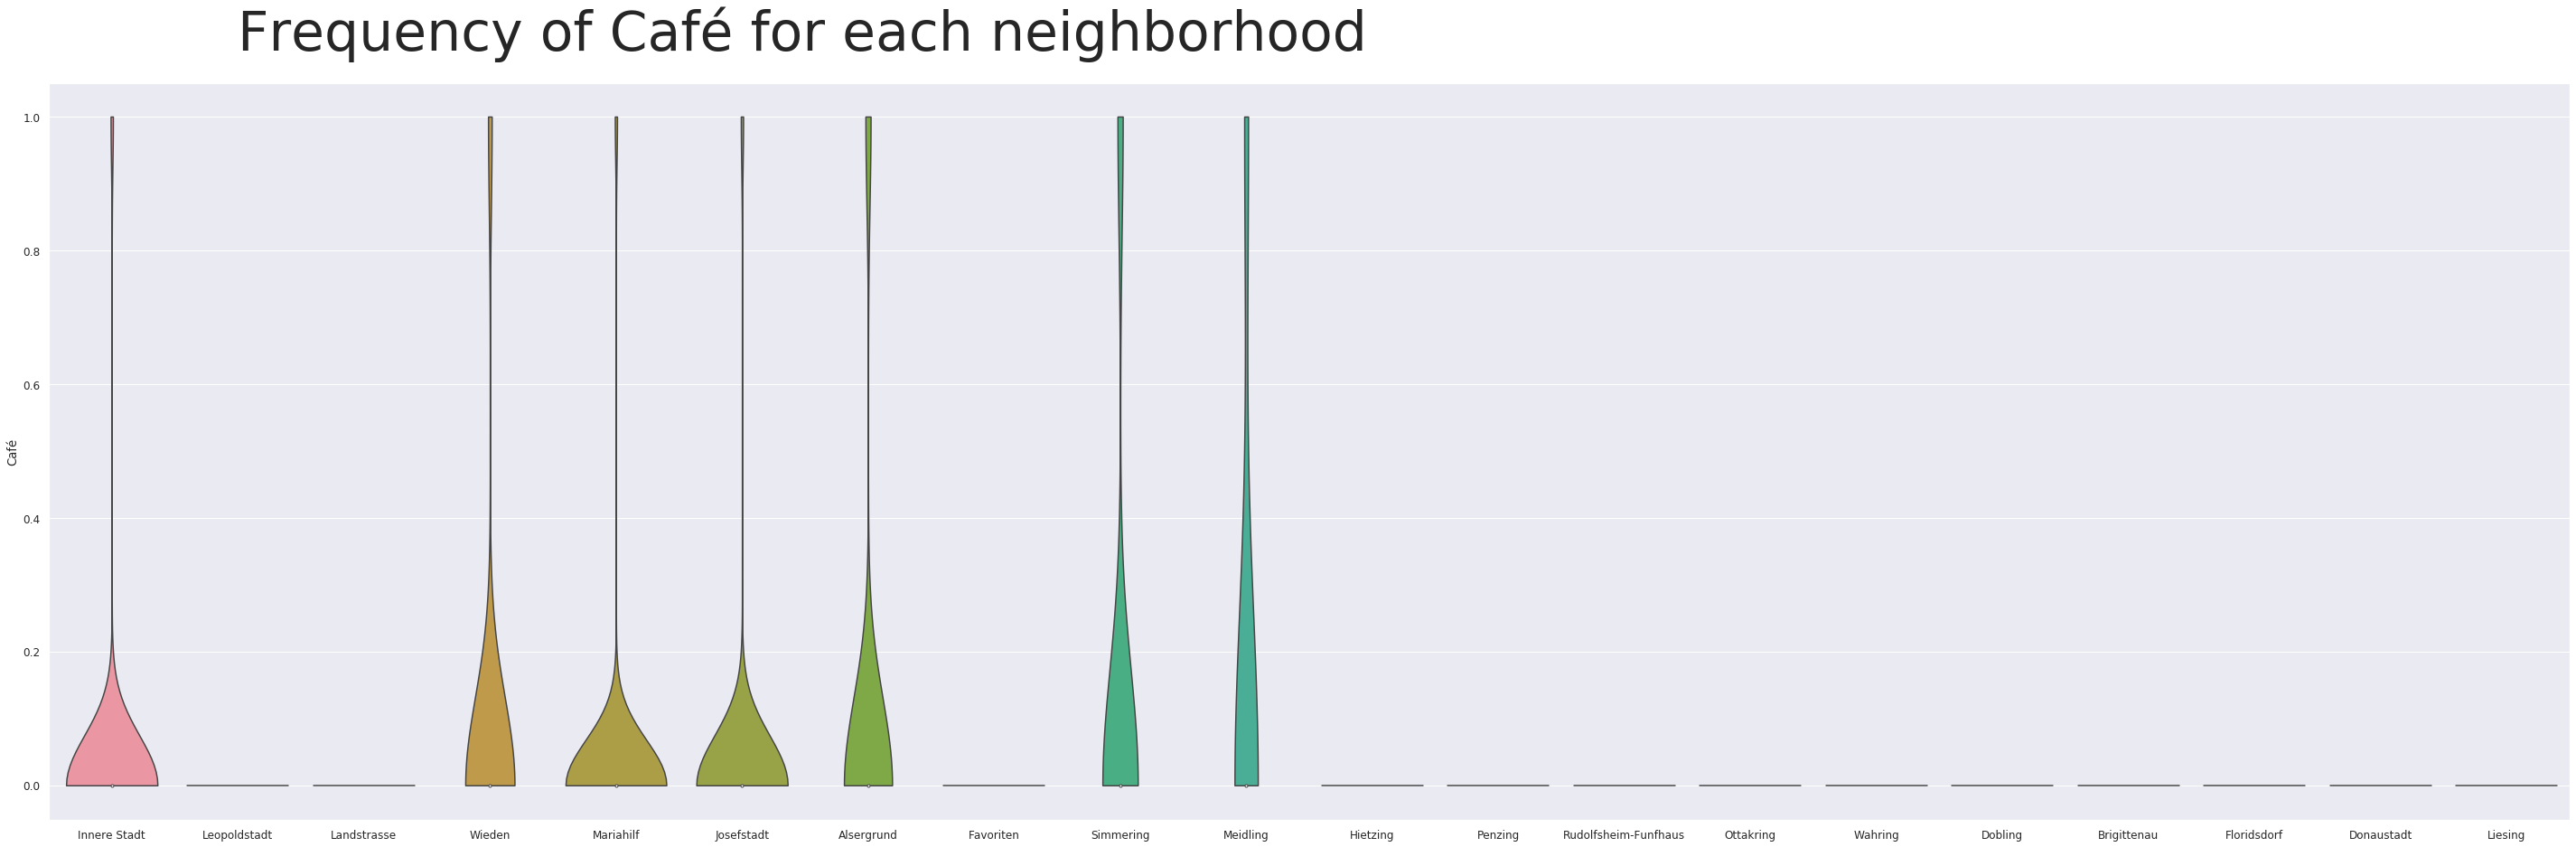

In [29]:
# Add the Cafe to explore this category
import seaborn as sns

fig = plt.figure(figsize=(50,15))
sns.set(font_scale=1.1)

ax = plt.subplot(1,1,1)
sns.violinplot(x="Neighborhood", y="Café", data=vienna_onehot, cut=0);
plt.xlabel("")

ax.text(1.0, 1.1, 'Frequency of Café for each neighborhood', fontsize=60)
plt.savefig ("Distribution_Frequency_Café_Venues.png", dpi=240)
plt.show()

### So there are 7 neighborhoods that have a significant frequency density of Café.

### Let's add this to the analysis with the other 3 specified categories as below

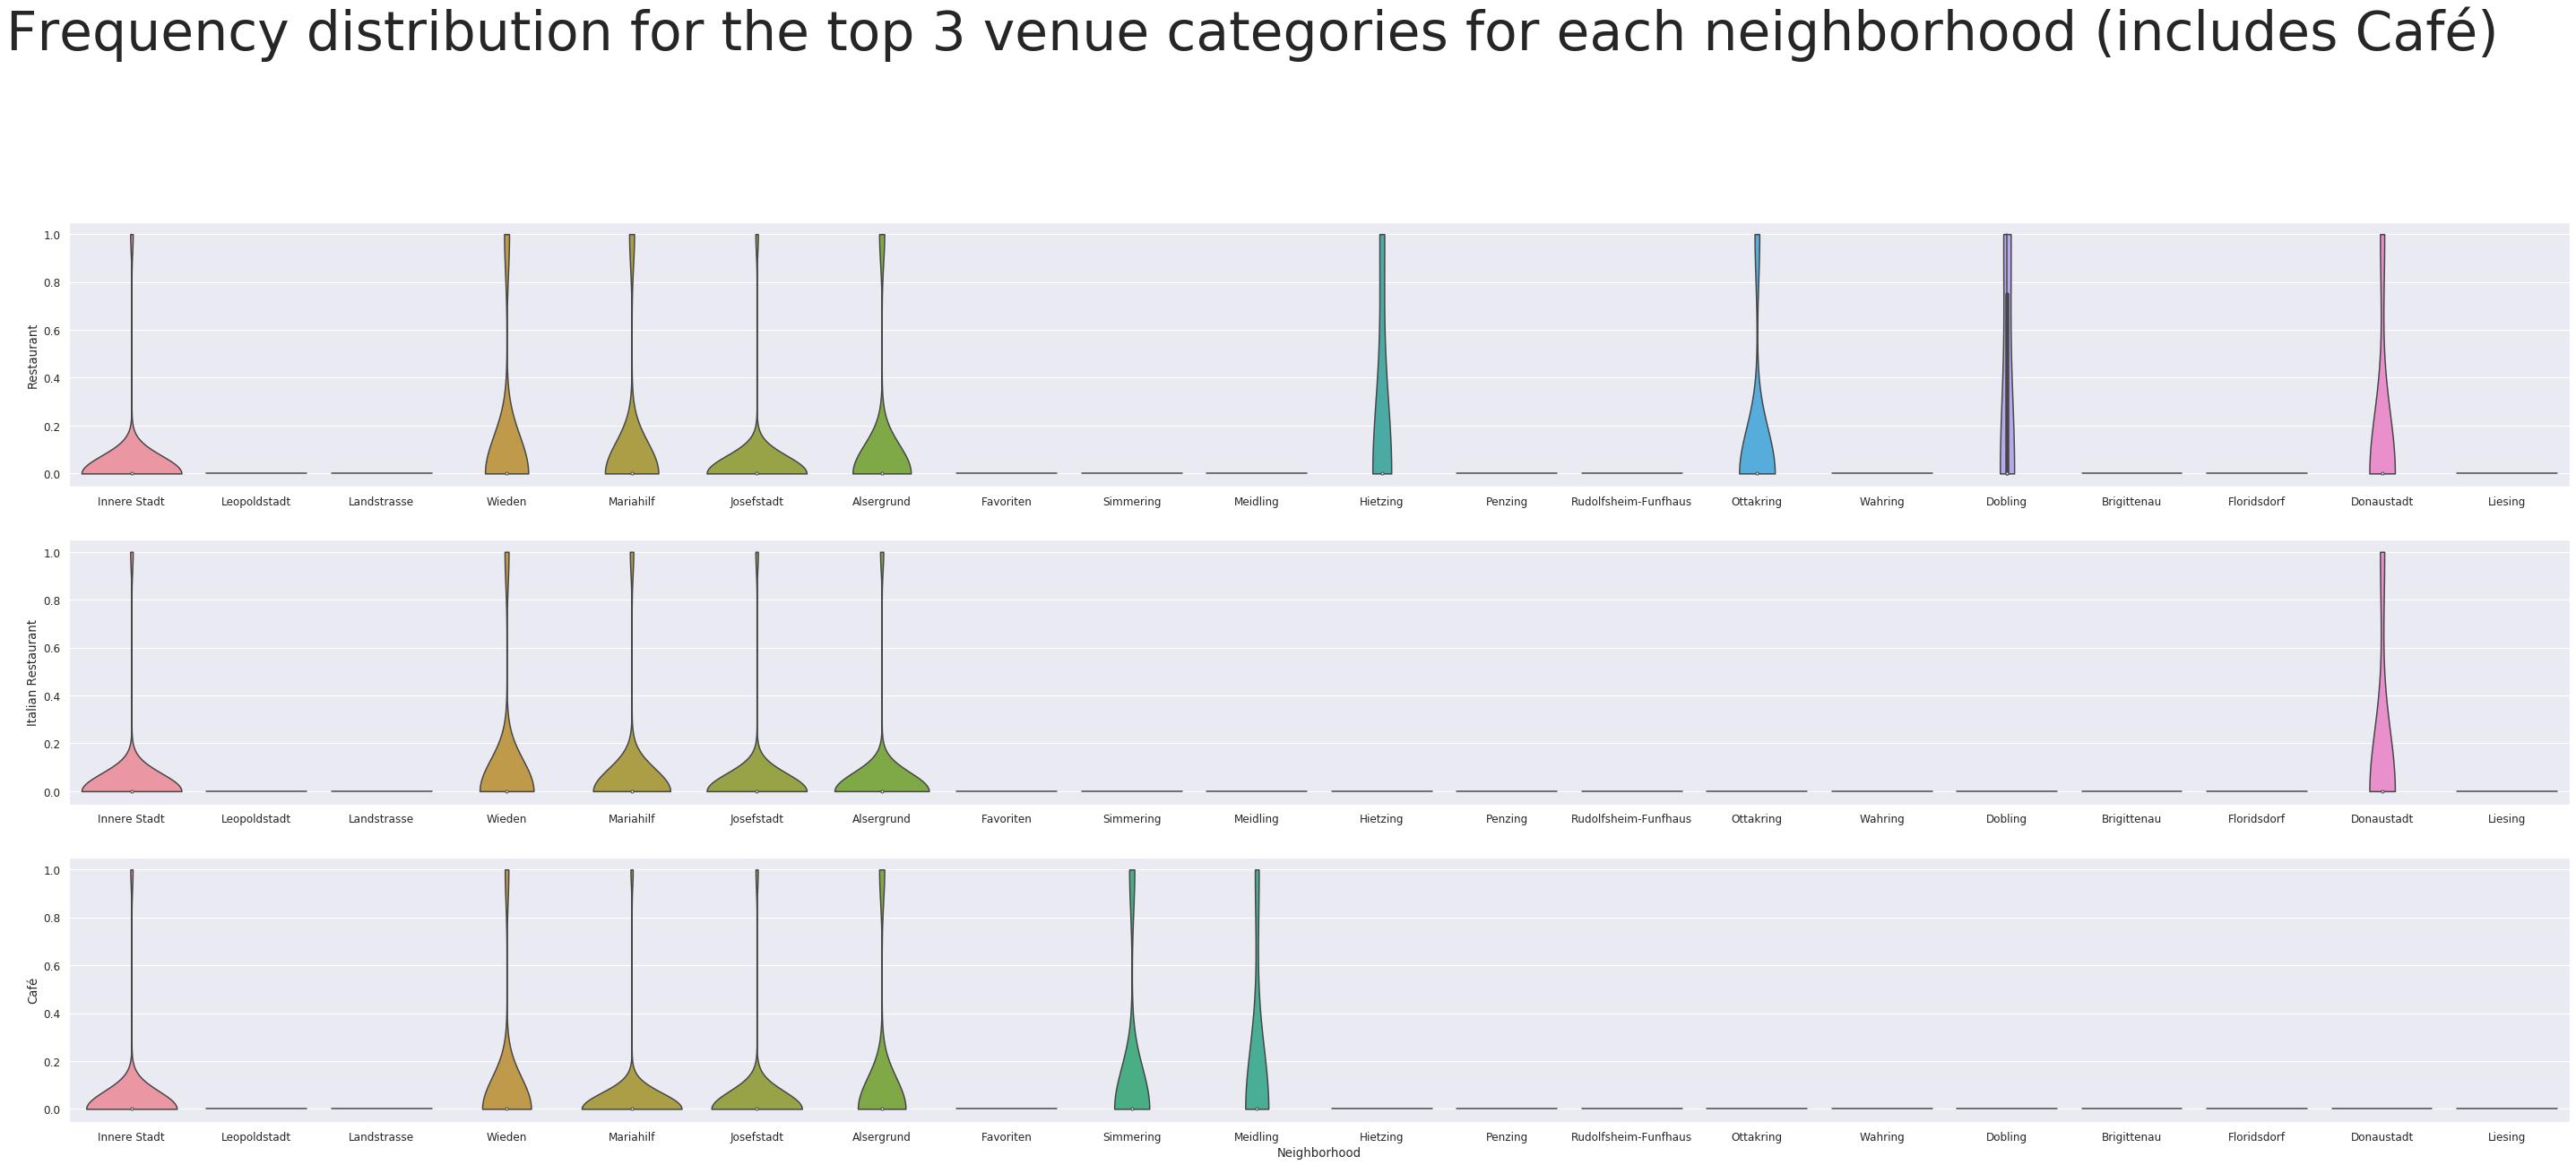

In [30]:
# Café has been added to explore this category and make a comparison

import seaborn as sns

fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(4,1,1)
sns.violinplot(x="Neighborhood", y="Restaurant", data=vienna_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(4,1,2)
sns.violinplot(x="Neighborhood", y="Italian Restaurant", data=vienna_onehot, cut=0);
plt.xlabel("")

plt.subplot(4,1,3)
sns.violinplot(x="Neighborhood", y="Café", data=vienna_onehot, cut=0);

ax.text(-1.0, 3.1, 'Frequency distribution for the top 3 venue categories for each neighborhood (includes Café)', fontsize=60)
plt.savefig ("Distribution_Frequency_Venues_3_categories_Café.png", dpi=240)
plt.show()

# 4 Inferences and Discussion

### Chosen Neighborhoods - Results
#### Inferential analysis using the data, as well as domain knowledge of retail and marketing, allow the list to be focused to just 5 neighborhoods from the previous 6.

#### The reasoning being that if the 3 criteria have been met - identifying neighborhoods that are lively with Restaurants and Italian Restaurants  - adding Cafe into the mix of food services in the area is a significant bonus. Huge verity of restaurant in the same area - give us insight that:
* a lot of people usually spent time here
* people loves to be here
* high concentration of people
* a competitive market.


### So the final 5 prospective neighborhoods for new restaurant are where 3 criteria are met:

* Inner Stadt
* Wieden
* Mariahilf
* Josefstadt
* Alsergrund


## Let's look at the 5 districts on a Vienna map

In [31]:
# The csv of the 3 chosen prospective neighborhoods was uploaded to GitHub for access and reference
# Download and put into a new dataframe called chosen_districts

chosen_districts = pd.read_csv('https://raw.githubusercontent.com/MyroslavY/github-example/master/Chosen.csv')
chosen_districts

,District,Population,Latitude,Longitude
0,Innere Stadt,16409,48.205833,16.368665
1,Wieden,32745,48.186999,16.356999
2,Mariahilf,31621,48.190499,16.343165
3,Josefstadt,25068,48.206499,16.342165
4,Alsergrund,43342,48.221832,16.354165


### Where are our chosen districts? Let's visualize them on a map of Vienna.

In [32]:
# Create a folium map of Paris with the 3 neighborhoods superimposed on the map
map_chosen_districts = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(chosen_districts['Latitude'], chosen_districts['Longitude'], chosen_districts['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=45,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_chosen_districts)  
    
map_chosen_districts

## Or for a closer view of Central Vienna

In [33]:
map_chosen_districts = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(chosen_districts['Latitude'], chosen_districts['Longitude'], chosen_districts['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_chosen_districts)  
    
map_chosen_districts

# Observations

#### As we can see, all district located in the central part of Vienna. Locations fitting the criteria for popular venues would normally be in central locations in many cities of the world. From beginning of our research we had 21 district. Without any data it would be extremely hard, time consuming and costly to do such research by visiting each of district. In our case we were able to collect the proper data and narrowed the search area down significantly from 21 potential districts to 3 that should suit the client's retail business.

# Inferences

#### We have made inferences from the data in making the location recommendations, but that is exactly the point. There is no right or wrong answer or conclusion for the task at hand. The job of data analysis here is to advise the best location. For sure, if we were able to use more specific data, such report will be more valuable. However, as we mentioned at the beginning of our case, this report will be more suitable for investors who just want to understand the market without any knowledge. 

# Conclusions

#### There are many ways this analysis could have been performed based on different methodologies and different data sources. In this study, I analyzed the districts in Vienna to understand which location is better for a new restaurant. I identified districts, Latitude, Longitude. After I used the folium map for building a visualization of districts. Then we use a foursquare API to check how many venues were returned for each neighborhood. I originally intended to use the clustering algorithm to cluster the data, but as it progressed it became obvious that this only complicated the task at hand. The analysis and results are not an endpoint, but rather a starting point that will guide the next part of the process to find a better place for a new restaurant. Without leveraging data to make focussed decisions, the process could have been drawn out and resulted in sub-standard areas for our stakeholders. Data has helped to provide a better strategy and way forward, these data-driven decisions will lead to a better solution in the end.